In [3]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.2


In [4]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

!git clone https://github.com/tensorflow/models.git

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] = '/content/models/research:/content/models/research/slim:' + os.environ['PYTHONPATH']

!python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
python-pil is already the newest version (5.1.0-1ubuntu0.3).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'models'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 41964 (delta 11), reused 18 (delta 0), pack-reused 41935
Receiving objects: 100% (41964/41964), 549.27 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (28514/28514), done.
/content/models/research
Traceback (most recent call last):
  File "object_detection/builders/model_builder_tes

Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 17s 423us/step - loss: 4.3305 - accuracy: 0.0462 - val_loss: 4.0247 - val_accuracy: 0.0935
Epoch 2/40
40000/40000 [==============================] - 12s 289us/step - loss: 3.7787 - accuracy: 0.1337 - val_loss: 3.6594 - val_accuracy: 0.1499
Epoch 3/40
40000/40000 [==============================] - 12s 289us/step - loss: 3.4755 - accuracy: 0.1831 - val_loss: 3.3999 - val_accuracy: 0.1973
Epoch 4/40
40000/40000 [==============================] - 12s 289us/step - loss: 3.2405 - accuracy: 0.2275 - val_loss: 3.2546 - val_accuracy: 0.2222
Epoch 5/40
40000/40000 [==============================] - 12s 289us/step - loss: 3.0744 - accuracy: 0.2602 - val_loss: 3.1421 - val_accuracy: 0.2451
Epoch 6/40
40000/40000 [==============================] - 12s 290us/step - loss: 2.9453 - accuracy: 0.2833 - val_loss: 3.0252 - val_accuracy: 0.2730
Epoch 7/40
40000/40000 [==============================] 

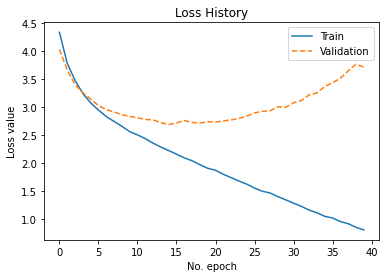

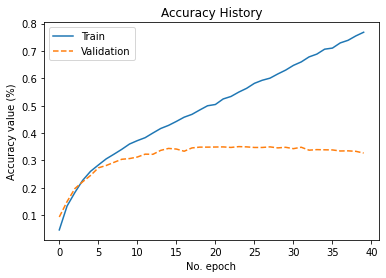

In [9]:
# required libraries and functions
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from keras.datasets import cifar100
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Layer

# create a neural ODE layer
class ODEBlock(Layer):

    def __init__(self, filters, kernel_size, **kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        super(ODEBlock, self).__init__(**kwargs)

    # one neural ODE block
    def build(self, input_shape):
        self.conv2d_w1 = self.add_weight("conv2d_w1", self.kernel_size + (self.filters + 1, self.filters), initializer='glorot_uniform')
        self.conv2d_w2 = self.add_weight("conv2d_w2", self.kernel_size + (self.filters + 1, self.filters), initializer='glorot_uniform')
        self.conv2d_b1 = self.add_weight("conv2d_b1", (self.filters,), initializer='zero')
        self.conv2d_b2 = self.add_weight("conv2d_b2", (self.filters,), initializer='zero')
        super(ODEBlock, self).build(input_shape)

    # integrating the ODE function by taking x as initial value
    def call(self, x):
        t = K.constant([0, 1], dtype="float32")
        return tf.contrib.integrate.odeint(self.ode_func, x, t, rtol=1e-3, atol=1e-3)[1]

    # defining the output
    def compute_output_shape(self, input_shape):
        return input_shape

    # the ode function that should be solved over time t for x as input and y as output
    def ode_func(self, x, t):
        y = self.concat_t(x, t)
        y = K.conv2d(y, self.conv2d_w1, padding="same")
        y = K.bias_add(y, self.conv2d_b1)
        y = K.relu(y)

        y = self.concat_t(y, t)
        y = K.conv2d(y, self.conv2d_w2, padding="same")
        y = K.bias_add(y, self.conv2d_b2)
        y = K.relu(y)

        return y
    def concat_t(self, x, t):
        new_shape = tf.concat(
            [
                tf.shape(x)[:-1],
                tf.constant([1],dtype="int32",shape=(1,))
            ], axis=0)

        t = tf.ones(shape=new_shape) * tf.reshape(t, (1, 1, 1, 1))
        return tf.concat([x, t], axis=-1)

# Neural ODE model
def build_model(input_shape, num_classes):
    x = Input(input_shape)
    y = Conv2D(32, (3, 3), activation='relu')(x)
    y = MaxPooling2D((2,2))(y)
    y = Conv2D(64, (3, 3), activation='relu')(y)
    y = MaxPooling2D((2,2))(y)
    y = ODEBlock(64, (3, 3))(y)
    y = Flatten()(y)
    y = Dense(num_classes, activation='softmax')(y)
    return Model(x,y)

# model configuration
batch_size = 1000
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = keras.losses.categorical_crossentropy
optimizer = keras.optimizers.Adam()
no_classes = 100
no_epochs = 40
validation_split = 0.2
verbosity = 1

# determine shape of the data
image_shape = (img_width, img_height, img_num_channels)

# load the dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# normalize the inputs
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# encode the outputs
y_train = keras.utils.to_categorical(y_train, no_classes)
y_test  = keras.utils.to_categorical(y_test, no_classes)

# create the neural ODE model
model = build_model(image_shape, no_classes)

# compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

# fit the data
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=verbosity,
          validation_split=validation_split)

# generate generalization metrics
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', round(score[0],2), 'Test accuracy:', round(score[1],2))

# results visualization
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], '--', label='Validation')
plt.legend()
plt.title('Loss History')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], '--', label='Validation')
plt.legend()
plt.title('Accuracy History')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()